Классификация по тональности
В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.



In [2]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:20, 2504.26it/s]


In [5]:
responses[0]['text']

'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор, мне по меньшей мере не понятно,\xa0 и почему по Вашей милости я должна переживать и бояться за себе и свое имущество. Письма доставляют мн

In [13]:
responses[0]['rating_not_checked']

False

In [14]:
print([responses[i]['rating_grade'] for i in range(100)])

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, 2, None, None, None, None, 1, None, None, None, None, None, None, None, None, None, None, None, None, None, 1, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 1, None, None, None, None, None, None, None, None, 1, None, None, None, None, None, None, None, None, 1, None, 1, None, 5, 3]


Классификация текстов

Часть 1. Анализ текстов

Посчитайте количество отзывов в разных городах и на разные банки


In [16]:
df =pd.DataFrame.from_dict(responses, orient ='columns')
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [17]:
df.groupby('city').count()['title'].reset_index().rename(columns ={'title':'answers_count'}).sort_values(by = 'answers_count', ascending =False)

,city,answers_count
2175,г. Москва,55354
3568,г. Санкт-Петербург,14342
1034,г. Екатеринбург,2337
2785,г. Новосибирск,2300
2672,г. Нижний Новгород,1976
...,...,...
2334,"г. Москва, Ногинск (Москва)",1
2333,"г. Москва, Новосибирск",1
2332,"г. Москва, Николоямская ул., 31",1
2330,"г. Москва, Московская область",1


Подготовка данных

In [18]:
wpt =nltk.WordPunctTokenizer()

text =df.text
data =[]

for t in text:
  response = wpt.tokenize(t)
  for r in response:
    data.append(r)

print(data[:10])
print(len(data))

['Добрый', 'день', '!', 'Я', 'не', 'являюсь', 'клиентом', 'банка', 'и', 'поручителем']
45608147


In [19]:
# Метод удаляет знаки препинания, приводит к к нижнему регистру, удаляет пустые строки и знаки препинания
def prep_text(data):
  out =[]
  for i in range(len(data)):
    if len(data[i])>2: # удаление коротких слов
      curr_d = data[i].lower()#нижний регистр
      reg= re.compile('[а-я]+')#удаление знаков препинания
      clean_word = reg.findall(curr_d)
      if clean_word !=[]:
        out.append(clean_word[0])
  return out

In [20]:
clear_data =  prep_text(data)
print(clear_data[:10])
print(len(clear_data))

['добрый', 'день', 'являюсь', 'клиентом', 'банка', 'поручителем', 'кредитному', 'договору', 'также', 'являюсь']
27108835


In [21]:
df =pd.DataFrame(clear_data,columns =['Words'])
df['count'] = 0
df.head(3)

,Words,count
0,добрый,0
1,день,0
2,являюсь,0


In [22]:
# чтобы не съэкномить ресурсы можно сгруппировать обработанные данные т.к. слова повторяются
df = df.groupby('Words').count().reset_index().sort_values(by='count', ascending=False)
df.head()

,Words,count
256728,что,640056
101574,мне,320958
8522,банка,275896
8521,банк,215419
76514,как,205680


In [23]:
len(df) # было 27108835 слов. Осталось:

263942

In [24]:
import re
! pip install pymorphy3
import pymorphy3
morph = pymorphy3.MorphAnalyzer()
# функция затратная по ресурсам!
def lemmatize (data):
  return  morph.parse( data)[0].normal_form

lemmatize('Клиенты')

'клиент'

In [25]:
# объем датафрейма уменьшился. Попробоуем лемматизировать слова.
df['lem_words'] = df['Words'].apply(lemmatize)
df.head()

,Words,count,lem_words
256728,что,640056,что
101574,мне,320958,я
8522,банка,275896,банк
8521,банк,215419,банк
76514,как,205680,как


In [26]:
df = df.groupby('lem_words')['count'].sum().reset_index()
df.head()

,lem_words,count
0,а,1406
1,аа,4
2,ааа,63
3,аааа,28
4,ааааа,12


In [27]:
# Определяем длину слова
df['length'] = df['lem_words'].str.len()
df.head()

,lem_words,count,length
0,а,1406,1
1,аа,4,2
2,ааа,63,3
3,аааа,28,4
4,ааааа,12,5


In [28]:
# Дополнительно удалим слова с count <2.
df = df.sort_values(by='length', ascending=True)
df.head(5)

,lem_words,count,length
0,а,1406,1
71120,с,503,1
35319,м,376,1
13201,г,13608,1
90626,щ,101,1


In [29]:
df = df.sort_values(by='length', ascending=False)
df.head(5)

,lem_words,count,length
11635,втечениенеделимыпередаемвашеделовслужбубезопас...,1,81
63604,приходомподписаниемвыпискойсчетомномеромдогово...,1,80
70410,роститеизвинитемысамитакстрадаемипереживаемчто...,1,73
52618,оченьнужнопрямоздесьсейчаслучшеневиделапрямоиз...,1,66
69922,роботисполнительбезвключениядополнительнойопци...,1,61


In [30]:
# Дополнительно удалим слова с count <2. и length<2

In [31]:
df = df[(df['count'] > 2) & (df['length']>2)]
df.head()

,lem_words,count,length
29434,клиентонеориентированность,3,26
43360,неклиентоориентированность,19,26
29457,клиентоориентированность,988,24
2432,антиклиентоориентировать,3,24
43361,неклиентоориентированный,14,24


In [32]:
df = df.sort_values(by='length', ascending=False).reset_index(drop = True)
df.head(10) 

,lem_words,count,length
0,клиентонеориентированность,3,26
1,неклиентоориентированность,19,26
2,клиентоориентированность,988,24
3,антиклиентоориентировать,3,24
4,неклиентоориентированный,14,24
5,рекламораспространитель,51,23
6,забюрократизированность,3,23
7,клиентоориетированность,10,23
8,высококвалифицированный,157,23
9,клиентоориентированость,12,23


Постройте гистограмы длин слов в символах и в словах
Найдите 10 самых частых:
слов
слов без стоп-слов
лемм
существительных


In [33]:
data = df.head(10)

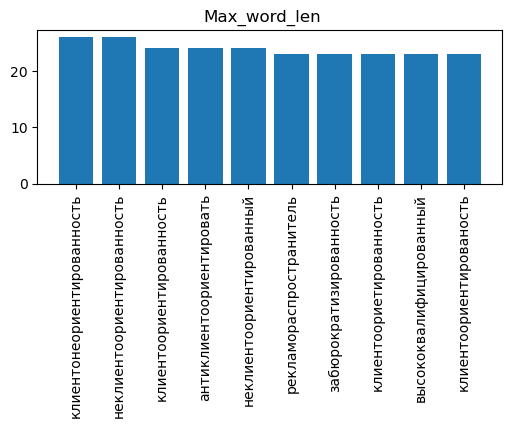

In [34]:
# Гистограмма длин слов.
matplotlib.rcParams['figure.figsize'] = [6,2]
names = data['lem_words']
values = data['length']
plt.bar(names, values)
plt.xticks(rotation='vertical')

plt.suptitle('Max_word_len')
plt.rcParams['figure.dpi'] = 120
plt.show()

In [35]:
df = df.sort_values(by='count', ascending=False).reset_index(drop = True)
df.head(10) 

,lem_words,count,length
0,банк,668538,4
1,что,662549,3
2,быть,421021,4
3,карта,334997,5
4,это,308689,3
5,мой,232454,3
6,как,205681,3
7,деньга,179817,6
8,день,173112,4
9,всё,171094,3


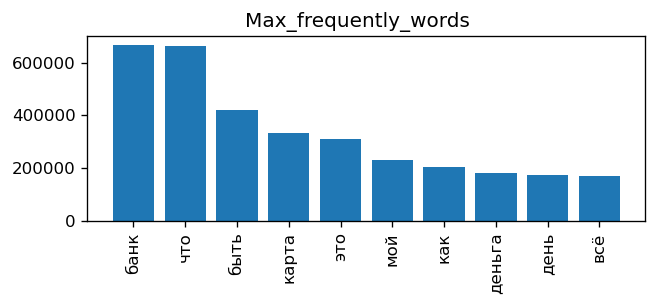

In [36]:
# 10 самых частых слов
# Гистограмма колчиества слов
data = df.head(10)
matplotlib.rcParams['figure.figsize'] = [6,2]
names = data['lem_words']
values = data['count']
plt.bar(names, values)
plt.xticks(rotation='vertical')
plt.suptitle('Max_frequently_words')
plt.rcParams['figure.dpi'] = 120
plt.show()

In [16]:
from nltk.corpus import stopwords
stop_words = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой', 'что', 'все', 'как'
]

In [38]:
stop_words [:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [39]:
df_without_stop =df
len(df_without_stop)

41859

In [40]:
df_without_stop = df_without_stop[~df_without_stop['lem_words'].isin(stop_words)]
df_without_stop.head()

,lem_words,count,length
0,банк,668538,4
3,карта,334997,5
7,деньга,179817,6
8,день,173112,4
9,всё,171094,3


In [41]:
len(df_without_stop)

41769

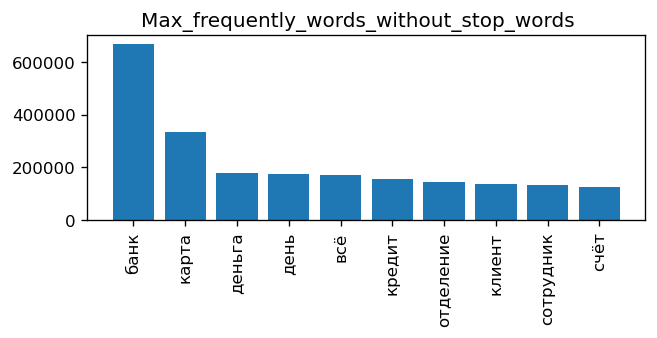

In [42]:
# 10 самых частых слов без стоп слов 
# Гистограмма длин слов.

data = df_without_stop.head(10)
matplotlib.rcParams['figure.figsize'] = [6,2]
names = data['lem_words']
values = data['count']
plt.bar(names, values)
plt.xticks(rotation='vertical')
plt.suptitle('Max_frequently_words_without_stop_words')
plt.rcParams['figure.dpi'] = 120
plt.show()

In [43]:
# поиск существительных
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Пример массива строк
sentences = [
    "Собака играет в парке.",
    "Кошка спит на диване.",
    "Машина быстро едет по дороге."
]

# Функция для нахождения существительных
def find_nouns(sentences):
    nouns = []
    for sentence in sentences:
        # Токенизация предложения
        words = nltk.word_tokenize(sentence)
        # Получение частей речи
        pos_tags = nltk.pos_tag(words)
        # Фильтрация существительных
        for word, tag in pos_tags:
            if tag in ['NN', 'NNS', 'NNP', 'NNPS']:  # Теги для существительных
                nouns.append(word)
    return nouns

# Вызов функции и вывод результата
nouns = find_nouns(sentences)
print("Найденные существительные:", nouns)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\koloskov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\koloskov\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Найденные существительные: ['играет', 'в', 'парке', 'спит', 'на', 'диване', 'быстро', 'едет', 'по', 'дороге']


In [44]:
nouns = find_nouns(df.lem_words)
nouns[:20]

['банк',
 'что',
 'быть',
 'карта',
 'это',
 'мой',
 'как',
 'деньга',
 'день',
 'всё',
 'кредит',
 'который',
 'так',
 'отделение',
 'клиент',
 'сотрудник',
 'мочь',
 'тот',
 'счёт',
 'этот']

In [45]:
df_nouns =df[df['lem_words'].isin(nouns)]
df_nouns.head()

,lem_words,count,length
0,банк,668538,4
1,что,662549,3
2,быть,421021,4
3,карта,334997,5
4,это,308689,3


In [46]:
len(df_nouns)

41859

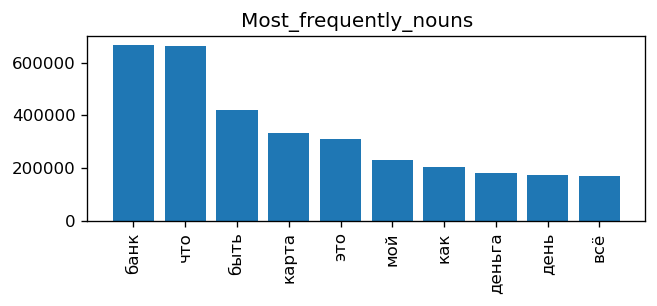

In [47]:
# метод отрабатывает, но не очень хорошо.
data = df_nouns.head(10)
matplotlib.rcParams['figure.figsize'] = [6,2]
names = data['lem_words']
values = data['count']
plt.bar(names, values)
plt.xticks(rotation='vertical')
plt.suptitle('Most_frequently_nouns')
plt.rcParams['figure.dpi'] = 120
plt.show()

Постройте кривые Ципфа и Хипса
Ответьте на следующие вопросы:
какое слово встречается чаще, "сотрудник" или "клиент"?
сколько раз встречается слова "мошенничество" и "доверие"?


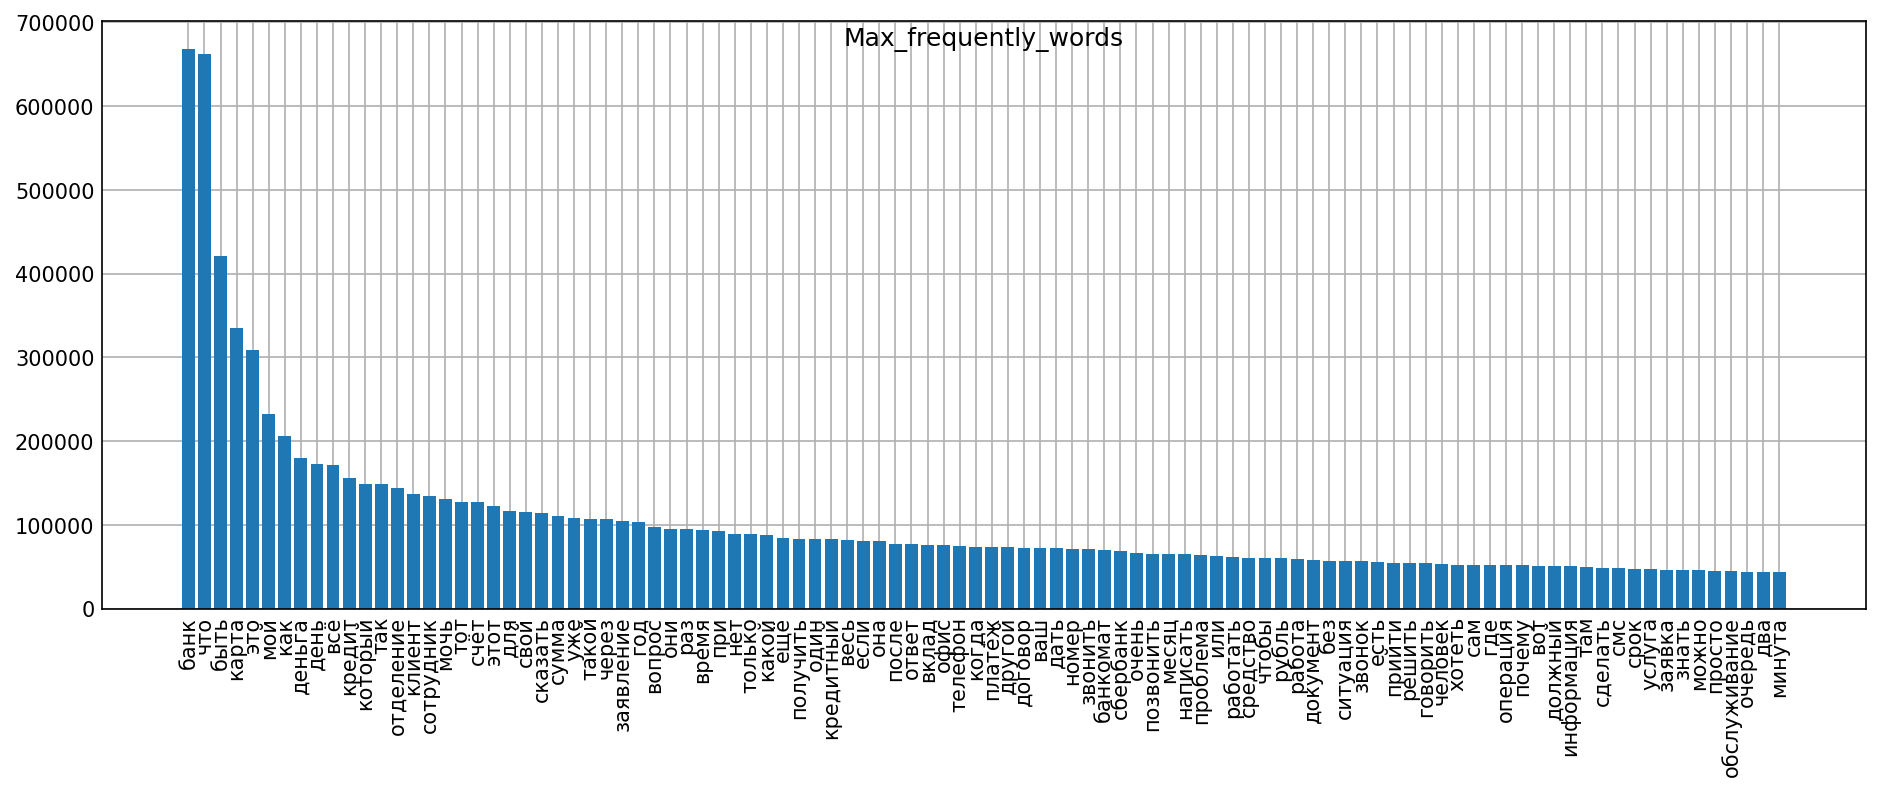

In [141]:
# Кривая ципфа. Показывает если все слова языка
#(или просто достаточно длинного текста) упорядочить
#по убыванию частотности их использования, то частотность n-го слова в 
#таком списке окажется приблизительно обратно пропорциональной его порядковому номеру.
# Здесь видно убывание но не совсем по этому закону.
data = df.head(100)
matplotlib.rcParams['figure.figsize'] = [12,4]
names = data['lem_words']
values = data['count']
plt.bar(names, values)
plt.xticks(rotation='vertical')
plt.suptitle('Max_frequently_words')
plt.rcParams['figure.dpi'] = 150
plt.show()

In [ ]:
# Закон Хибса. 
# Для построения кривой нужно узнать количество уникальных слов в отзывах.
# и количество слов в отзывах. 

In [238]:
df =pd.DataFrame.from_dict(responses, orient ='columns')
df = df[['text']]
df.head()

,text
0,Добрый день! Я не являюсь клиентом банка и пор...
1,Доброго дня! Являюсь держателем зарплатной кар...
2,Здравствуйте! Дублирую свое заявление от 03.0...
3,Добрый день!! Я открыл расчетный счет в СберБа...
4,"04.03.2015 г. взяла кредит в вашем банке, заяв..."


In [244]:
df['text'] = df['text'].str.replace(r'[^А-Яа-я ]*','', regex=True) # удаление символов. Останутся слова и пробелы
df.head()

,text,count,unique
0,я не и по а также не с по с из мой с о в котор...,69,28
1,в в о мне на не на на с в он что в я все под т...,33,20
2,от в до по была в на но с два по то есть о чем...,26,18
3,я в как все было бы хорошо если бы не но по не...,53,31
4,в была т и на же на то что и потом мне по я вс...,121,41


In [245]:
df = df['text'].str.lower().reset_index() # перевод в нижний регшистр
df = df[['text']]
df.head()

,text
0,я не и по а также не с по с из мой с о в котор...
1,в в о мне на не на на с в он что в я все под т...
2,от в до по была в на но с два по то есть о чем...
3,я в как все было бы хорошо если бы не но по не...
4,в была т и на же на то что и потом мне по я вс...


In [13]:
# удаление стоп слов
def remove_stop_words(text):
    return ' '.join(w for w in text.split() if w in stop_words)

df['text'] = df['text'].apply(remove_stop_words)
df.head()

NameError: name 'stop_words' is not defined

In [247]:
# Определяем количество слов в строке
df['count'] = df['text'].apply(lambda x: len(x.split()))
df.head()

,text,count
0,я не и по а также не с по с из мой с о в котор...,69
1,в в о мне на не на на с в он что в я все под т...,33
2,от в до по была в на но с два по то есть о чем...,26
3,я в как все было бы хорошо если бы не но по не...,53
4,в была т и на же на то что и потом мне по я вс...,121


In [248]:
# определяем количество уникальных слов в строке
df['unique'] = df['text'].apply(lambda x: len(set(x.split())))
df.head()

,text,count,unique
0,я не и по а также не с по с из мой с о в котор...,69,28
1,в в о мне на не на на с в он что в я все под т...,33,20
2,от в до по была в на но с два по то есть о чем...,26,18
3,я в как все было бы хорошо если бы не но по не...,53,31
4,в была т и на же на то что и потом мне по я вс...,121,41


In [269]:
df1 =df

df1 =df1.sort_values('count')
# слов много. Чтобы облегчить сделаем аггрегацию
df1 = df1[['count','unique']].groupby('count').mean()
df1.reset_index(inplace=True)
df1 =df1.sort_values('count')
df1

,count,unique
0,0,0.000000
1,1,1.000000
2,2,1.957447
3,3,2.816667
4,4,3.728814
...,...,...
761,1236,129.000000
762,1465,140.000000
763,1526,135.000000
764,1663,136.000000


In [283]:
# Осталось вычислить Y

b=0.4 #коэффициент для кривой Хипса варьируется от 0.4 до 0.6
K = 50 #константа для кривой Хипса. Варьируется от 10 до 100.


df1['Y'] = K*df1['count']**b
df1.head()

,count,unique,Y
0,0,0.000000,0.000000
1,1,1.000000,50.000000
2,2,1.957447,65.975396
3,3,2.816667,77.592279
4,4,3.728814,87.055056


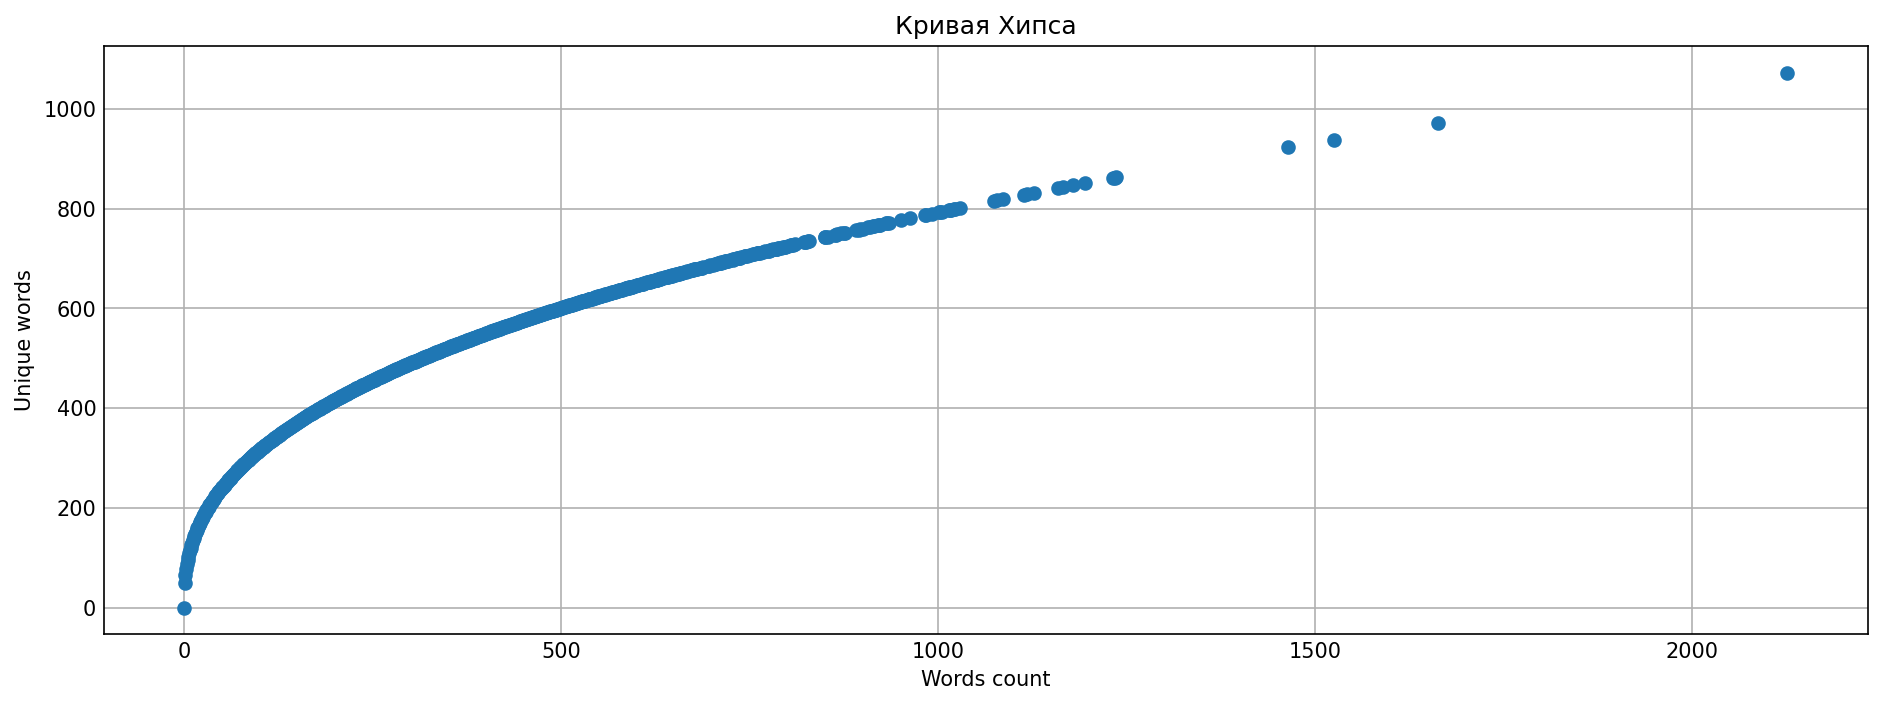

In [284]:
# Теперь можно строить
# Выхода на "полку" не видно, но рост явно не линейный
x = df1['count']
y = df1['Y']
plt.scatter(x, y)
plt.xlabel("Words count")  # Подпись для оси X
plt.ylabel("Unique words")  # Подпись для оси Y
plt.title('Кривая Хипса')
plt.show()

В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру
, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)


In [413]:
df =pd.DataFrame.from_dict(responses, orient ='columns')
df = df[['text','rating_grade']]
df= df.dropna(subset=['rating_grade'])
df =df[(df['rating_grade'] == 5) | (df['rating_grade'] == 1)]
df.head()

,text,rating_grade
19,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0
33,Доброго времени! Вчера мне поступило смс-уведо...,1.0
76,"05.06.2015г. около 15 часов, пришел в указанны...",1.0
85,Для оплаты коммунальных платежей пользуюсь пла...,1.0
94,В апреле этого года пришла в отделение сбербан...,1.0


In [414]:
df_good = df[df.rating_grade==5.0]
df_good.head(1)

,text,rating_grade
98,Досрочно закрывали вклады перед отпуском. Жена...,5.0


In [415]:
df_bad = df[df.rating_grade==1.0]
df_bad.head(1)

,text,rating_grade
19,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0


In [416]:
from collections import Counter
from nltk.tokenize import word_tokenize

corpus_good = [token for answer in df_good.text for token in word_tokenize(answer) if token not in punctuation]
print(len(corpus))
corpus_good[:10]# punctiation deleted

5867786


['Досрочно',
 'закрывали',
 'вклады',
 'перед',
 'отпуском',
 'Жена',
 'заказывала',
 'заранее',
 'но',
 'забыла']

In [417]:
corpus_bad = [token for answer in df_bad.text for token in word_tokenize(answer) if token not in punctuation]
print(len(corpus))
corpus_bad[:10]# punctiation deleted

5867786


['Открыт', 'вклад', 'и', 'счет', 'в', 'USD', 'Плюс', 'к', 'этому', 'есть']

In [418]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [419]:
freq_dict_good = Counter(corpus_good)
freq_dict_good.most_common(20)

[('и', 101364),
 ('в', 100920),
 ('не', 56894),
 ('на', 54580),
 ('что', 41631),
 ('с', 38247),
 ('я', 32115),
 ('по', 27623),
 ('мне', 19409),
 ('банка', 19341),
 ('все', 19047),
 ('за', 18481),
 ('как', 16957),
 ('меня', 15913),
 ('``', 15608),
 ("''", 15454),
 ('но', 14712),
 ('В', 14053),
 ('а', 14029),
 ('это', 13732)]

In [420]:
len(freq_dict_good)

133825

In [421]:
sum_good_words = 0
for v in freq_dict_good.values():
    sum_good_words+=v
sum_good_words

3189188

In [422]:
freq_dict_bad = Counter(corpus_bad)
freq_dict_bad.most_common(20)

[('в', 425974),
 ('и', 347674),
 ('не', 303238),
 ('что', 233965),
 ('на', 230338),
 ('я', 169272),
 ('с', 149014),
 ('по', 120240),
 ('мне', 117444),
 ('банка', 84474),
 ('``', 84141),
 ("''", 81848),
 ('меня', 65035),
 ('а', 60057),
 ('как', 59442),
 ('это', 57126),
 ('у', 56992),
 ('банк', 56616),
 ('за', 56537),
 ('В', 55626)]

In [423]:
sum_bad_words = 0
for v in freq_dict_bad.values():
    sum_bad_words+=v
sum_bad_words

13261047

In [424]:
len(freq_dict_bad)

295738

In [425]:
sum_bad_words/sum_good_words
# Если сравнивать по количеству слов, то видно, 
#что отрицательные отзывы в 4 с лишним раза длиннее.
# отнормируем слова и сравним количество.

4.1581264572674925

In [426]:
for k,v in freq_dict_good.items():
    curr_val = (v/sum_good_words)*100
    freq_dict_good[k] = curr_val

freq_dict_good.most_common(20)

[('и', 3.178363897017046),
 ('в', 3.1644418579274727),
 ('не', 1.783965071986976),
 ('на', 1.7114074178129355),
 ('что', 1.3053793003109255),
 ('с', 1.1992707861687677),
 ('я', 1.0069961382019499),
 ('по', 0.8661452382236482),
 ('мне', 0.608587515066531),
 ('банка', 0.6064553108816414),
 ('все', 0.5972366633763829),
 ('за', 0.5794891991315658),
 ('как', 0.5317027406349203),
 ('меня', 0.4989671352080843),
 ('``', 0.4894035723199761),
 ("''", 0.48457475696007885),
 ('но', 0.4613086465896648),
 ('В', 0.4406450795625721),
 ('а', 0.4398925369090816),
 ('это', 0.4305798215721368)]

In [427]:
for k,v in freq_dict_bad.items():
    curr_val = v/sum_bad_words
    freq_dict_bad[k] = curr_val

freq_dict_bad.most_common(20)

[('в', 0.03212219970263283),
 ('и', 0.026217688542993625),
 ('не', 0.022866821903278073),
 ('что', 0.01764302622560647),
 ('на', 0.017369518409820883),
 ('я', 0.01276460297591887),
 ('с', 0.01123697095711975),
 ('по', 0.009067157366986182),
 ('мне', 0.008856314286496383),
 ('банка', 0.006370085257973975),
 ('``', 0.006344974118559417),
 ("''", 0.006172061678086202),
 ('меня', 0.004904213068545794),
 ('а', 0.004528827927387634),
 ('как', 0.0044824514987391265),
 ('это', 0.004307804655243285),
 ('у', 0.004297699872415806),
 ('банк', 0.004269346153437206),
 ('за', 0.004263388856098617),
 ('В', 0.0041946914146371705)]

In [ ]:
#Теперь видно что в отрицательном отдыве очень много предлогов. Очень много частиц "не", "на", 'что',
# метоимений "я", наречия "как" и его форм. При длине словаря 300 тыс - это много. Люди довольные отзывами вобще их редко используют.
#И словарный запас у более разнообразен.

Часть 2. Тематическое моделирование
Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.


In [43]:
df =pd.DataFrame.from_dict(responses, orient ='columns')
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [44]:
df =df[['title','text']]
df.head()# возбмем за тему название банка

,title,text
0,Жалоба,Добрый день! Я не являюсь клиентом банка и пор...
1,Не могу пользоваться услугой Сбербанк он-лайн,Доброго дня! Являюсь держателем зарплатной кар...
2,Двойное списание за один товар.,Здравствуйте! Дублирую свое заявление от 03.0...
3,Меняют проценты комиссии не предупредив и не ...,Добрый день!! Я открыл расчетный счет в СберБа...
4,Верните денежные средства за страховку,"04.03.2015 г. взяла кредит в вашем банке, заяв..."


In [45]:
len(df)

153499

In [49]:
df.title.value_counts()[0:30] 

title
                                1223
Претензия                        364
Кредитная карта                  317
Жалоба                           286
Благодарность                    248
Звонки из банка                  203
Банкомат съел деньги             176
Автокредит                       163
Телефонный терроризм             158
Потребительский кредит           157
Перевыпуск карты                 155
Отвратительное обслуживание      152
Хороший банк                     150
Некомпетентность сотрудников     147
Отличный банк                    146
Ипотека                          144
Открытие вклада                  130
Звонки                           122
Украли деньги с карты            119
Обслуживание                     119
Реструктуризация                 118
Ужасное обслуживание             115
Кредит                           112
Досрочное погашение              104
Страховка                        102
Качество обслуживания             99
Некомпетентные сотрудники       

In [50]:
title = df.title.value_counts()[5:11].reset_index()# попробуем разелить эти категории. 
#Общее может быть по автокредиту и потребительскому кредиту.
title = title['title']
title

0           Звонки из банка
1      Банкомат съел деньги
2                Автокредит
3      Телефонный терроризм
4    Потребительский кредит
5          Перевыпуск карты
Name: title, dtype: object

In [51]:
df = df[df['title'].isin(title)]# объем выборки очень большой.
# Лемматизация уже потребляет очень много ресурсов. 
df.head()

,title,text
213,Телефонный терроризм,"Уважаемый банк! Прекратите мне звонить, на как..."
437,Звонки из банка,Интересует такой вопрос. Почему мне звонят с н...
439,Телефонный терроризм,Здравствуйте! Являюсь клиентом Вашего банка уж...
736,Потребительский кредит,Муж как корпоративный клиент обратился за потр...
888,Телефонный терроризм,"Мне, C-шкину Андрею Дмитриевичу 1973 г.р. регу..."


In [52]:
len(df)

1012

In [53]:
import pymorphy3
m = pymorphy3.MorphAnalyzer()

In [54]:
import re
from nltk.corpus import stopwords

In [55]:
mystopwords = stopwords.words('russian')
ru_words = re.compile("[А-Яа-я]+")


def words_only(text): # перевод в слова с пробелами
    return " ".join(ru_words.findall(text))

# приведение слов к нормальной форме
def lemmatize(text, mystem=m):
    try:
        return " ".join([m.parse(w)[0].normal_form for w in text.split(' ')]).strip()  
    except:
        return " "
# удаление стоп слов
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

 # метод который включает в себя пердыдущие методы плюс переводит в нижний регистр   
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [56]:
%%time
from tqdm.notebook import tqdm

df.text = df.text.apply(preprocess)

CPU times: total: 30.3 s
Wall time: 34.8 s


In [57]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [58]:
texts = [text.split() for text in df.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [59]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [60]:
%%time
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

CPU times: total: 562 ms
Wall time: 645 ms


In [61]:
len(corpus)

1012

In [62]:
sims[0]

array([1.        , 0.01290996, 0.0334243 , ..., 0.00981626, 0.00900107,
       0.        ], dtype=float32)

In [63]:
import seaborn as sns

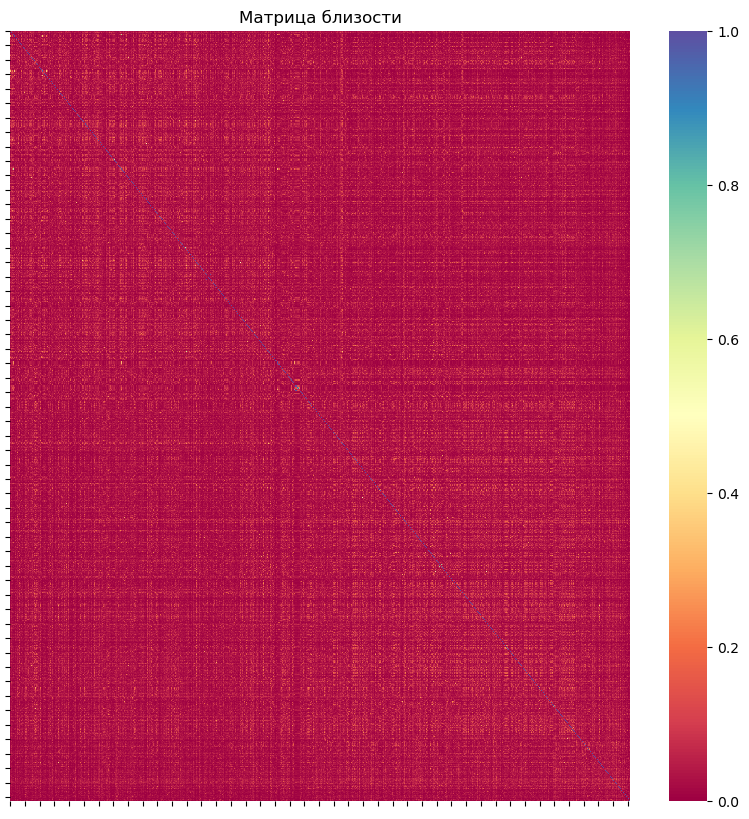

In [64]:
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title("Матрица близости")# матрица близости тем. На сколько они похожи.
plt.show()# вообще ничего ни на что не похоже.

In [65]:
# попробуем латентно-семантический анализ

In [66]:
from gensim.models import lsimodel

In [67]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

CPU times: total: 1.62 s
Wall time: 821 ms


In [68]:
lsi.show_topics(5)

[(0,
  '-0.221*"карта" + -0.164*"банкомат" + -0.151*"деньга" + -0.119*"номер" + -0.116*"ваш" + -0.114*"звонок" + -0.114*"кредит" + -0.104*"отделение" + -0.102*"заявление" + -0.101*"телефон"'),
 (1,
  '-0.282*"банкомат" + -0.236*"карта" + 0.211*"ваш" + 0.207*"звонок" + -0.202*"деньга" + 0.186*"номер" + 0.163*"телефон" + 0.132*"поступать" + 0.120*"человек" + 0.112*"звонить"'),
 (2,
  '0.412*"банкомат" + 0.229*"деньга" + -0.186*"карта" + 0.146*"купюра" + -0.143*"заявка" + -0.142*"перевыпуск" + 0.129*"претензия" + 0.121*"чек" + 0.116*"номер" + 0.115*"операция"'),
 (3,
  '0.521*"карта" + 0.262*"перевыпуск" + -0.173*"кредит" + -0.165*"сумма" + 0.142*"перевыпустить" + -0.140*"заявка" + 0.131*"готовый" + -0.129*"договор" + -0.126*"платёж" + -0.119*"машина"'),
 (4,
  '-0.436*"заявка" + 0.238*"платёж" + 0.169*"сумма" + -0.151*"рассмотрение" + 0.143*"рубль" + 0.135*"договор" + -0.128*"решение" + 0.126*"карта" + -0.109*"позвонить" + 0.108*"руб"')]

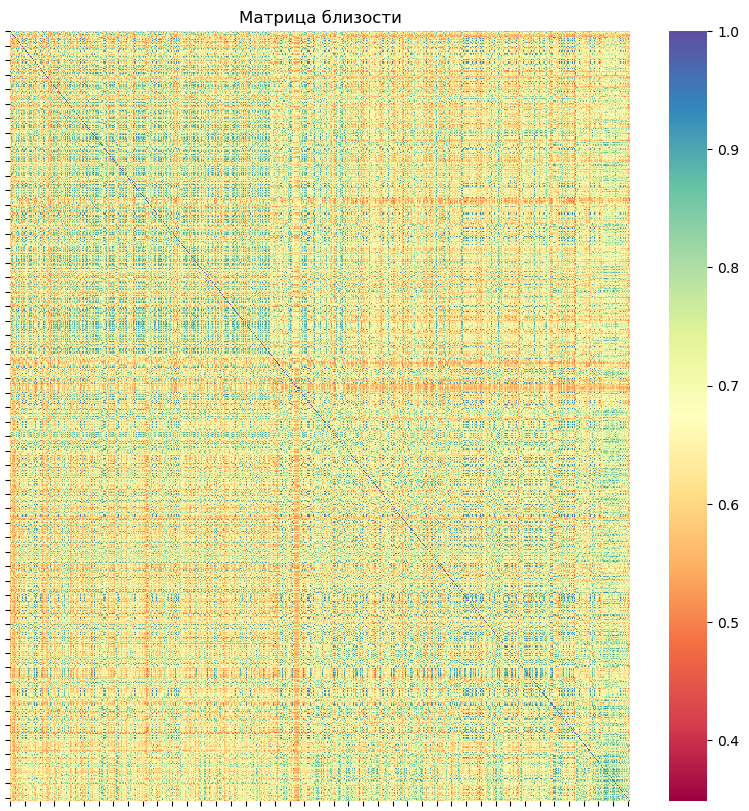

In [69]:
corpus_lsi = lsi[corpus]
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[corpus_lsi]
sims  = (sims + 1)/2.
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()
# Здесь уже видно, что некоторые темы перемешаны, но есть и общее

C:\Users\koloskov\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


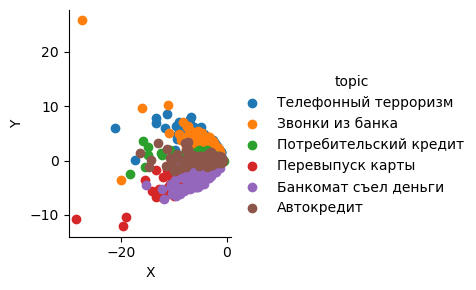

In [70]:
X = [0] * len(df)
Y = [0] * len(df)
for i in range(len(df)):
    vec = corpus[i]
    LSI_topics = (lsi[vec])
    for topic in LSI_topics:
        if topic[0] == 0:
            X[i] = topic[1]
        elif topic[0] == 1:
            Y[i] = topic[1]

vis_df = pd.DataFrame({'X': X, 'Y': Y, 'topic' : df.title})

sns.FacetGrid(vis_df, hue="topic").map(plt.scatter, "X", "Y").add_legend()

# по графику видно,что темы немного отличаются но видно и разеление.

In [71]:
# Применим TNSE
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [72]:
vectors = TfidfVectorizer().fit_transform(df.text) # строим тф-идф матрицу документ-слово
X_reduced = TruncatedSVD(n_components=5, random_state=0).fit_transform(vectors) # оставляем n главных компонент

In [73]:
# %%time
X_embedded = TSNE(n_components=2, perplexity=5, verbose=0).fit_transform(X_reduced) # строим мэппинг в двухмерную плоскость с TSNE

C:\Users\koloskov\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


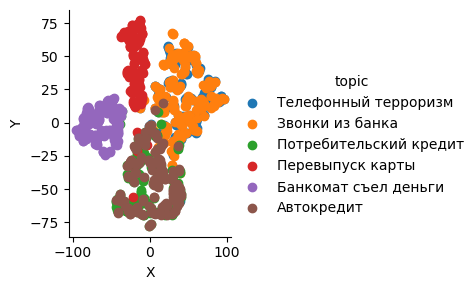

In [74]:
vis_df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'topic' : df.title})
sns.FacetGrid(vis_df, hue="topic").map(plt.scatter, "X", "Y").add_legend()
# Здесь видно, что темы "Банкомат сьел деньги" и "Перевыпуск карты" знгачительно отделяются.
# "Звонки из банка" и "Телефонный терроризм" так же слабо отличаются т.к. речь идет о звонках.
# "Автокредит" и "Потребительский кредит" так же слабо различаются. 

Часть 3. Классификация текстов
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных
-грам.
Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
1-ый вариант:
 преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.
В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

In [5]:
df =pd.DataFrame.from_dict(responses, orient ='columns')
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [6]:
import numpy as np
df = df[['text','rating_grade']]
df= df.dropna(subset=['rating_grade'])
df.head()

,text,rating_grade
14,"Также как и многие давний клиент банка, был до...",2.0
19,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0
33,Доброго времени! Вчера мне поступило смс-уведо...,1.0
76,"05.06.2015г. около 15 часов, пришел в указанны...",1.0
85,Для оплаты коммунальных платежей пользуюсь пла...,1.0


In [7]:
df =df[(df['rating_grade'] == 5) | (df['rating_grade'] == 1)]
df.head(10)

,text,rating_grade
19,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0
33,Доброго времени! Вчера мне поступило смс-уведо...,1.0
76,"05.06.2015г. около 15 часов, пришел в указанны...",1.0
85,Для оплаты коммунальных платежей пользуюсь пла...,1.0
94,В апреле этого года пришла в отделение сбербан...,1.0
96,"В продолжение истории, которая тянется с марта...",1.0
98,Досрочно закрывали вклады перед отпуском. Жена...,5.0
101,Являюсь клиентом данного банка года с 2004 или...,1.0
103,Отвратительное отношение к вкладчикам. Пришел ...,1.0
105,"Сегодня, 3 июня, в ДО ""Тихвинский"" отказали в ...",1.0


In [17]:
df['text'] = df['text'].str.replace(r'[^А-Яа-я ]*','', regex=True) # удаление символов. Останутся слова и пробелы

df['text_lower']= df['text'].str.lower() # перевод в нижний регшистр
df = df[['text_lower','rating_grade']]
df.columns = ['text','rating_grade']

df['text'] = df['text'].apply(remove_stop_words) #удаление стоп слов.

df.head()

,text,rating_grade
19,и в к есть в в с на на для или и в прошлый раз...,1.0
33,мне о том что мне по в но в с в без не мне об ...,1.0
76,в с мне что с под чем при этом на когда я на в...,1.0
85,для и с на это а после не при из не и его,1.0
94,в этого в на свой в со на меня в там моя и со ...,1.0


In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.text, df.rating_grade)


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer # дает каждому слдову вектор

In [30]:
vec = CountVectorizer(ngram_range = (1,2)) #рассматриваем отдельные слова и биграммы (1,2)
bow = vec.fit_transform(x_train)# используется мешок слов.

In [31]:
list(vec.vocabulary_.items())[:20]

[('был', 858),
 ('на', 9693),
 ('она', 12892),
 ('чтобы', 20231),
 ('там', 16786),
 ('ей', 4785),
 ('что', 19945),
 ('только', 17909),
 ('не', 10533),
 ('через', 19794),
 ('они', 13043),
 ('будет', 449),
 ('нельзя', 11115),
 ('еще', 5367),
 ('при', 14465),
 ('этом', 21093),
 ('быть', 1454),
 ('по', 13632),
 ('за', 5669),
 ('ее', 4636)]

In [25]:
clf = LogisticRegression(random_state = 42, solver = 'liblinear')
clf.fit (bow, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [26]:
from sklearn.metrics import classification_report

pred = clf.predict(vec.transform(x_test))
print (classification_report(pred,y_test))

              precision    recall  f1-score   support

         1.0       0.92      0.90      0.91     12087
         5.0       0.66      0.72      0.69      3438

    accuracy                           0.86     15525
   macro avg       0.79      0.81      0.80     15525
weighted avg       0.86      0.86      0.86     15525



In [27]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(pred,y_test)

In [28]:
acc

0.8566183574879227

In [29]:
from sklearn.metrics import  f1_score
f1_score(pred,y_test, average="macro")

0.797885450660297

По частям 1 и 2 всё отлично, в части 3 первая часть хорошо, но пока не хватает:
2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.
Добавьте это, и будет зачёт

In [ ]:
#Что здесь происоходит: Сначала мы преобразуем слов в векторы с помощью CountVectorizer.
# Он поступает на вход LatentDirichletAllocation. Цель ЛДА -получить скрытую структуру темы. т.е.
# он дает коэффициенты на выход, а не результат.
# Затем на эти коэффициенты обарбатываются логистической регрессией, которая делит данные по темам.

In [68]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
# пайплайн позволяет обучить одну модель и да наддые полученные на выход одной модели подать на ход другой.

clf = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,2))),
    ('lda', LatentDirichletAllocation(n_components=10, learning_method='batch',max_iter=10, batch_size=128, random_state=42)),
    ('lr', LogisticRegression(random_state = 42, solver = 'liblinear'))
])


model = clf.fit(x_train, y_train)
model



Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('lda', LatentDirichletAllocation(random_state=42)),
                ('lr',
                 LogisticRegression(random_state=42, solver='liblinear'))])

In [69]:
model.score(x_train, y_train)# обучение прошло верно

0.8245625335480408

In [70]:
y_pred = model.predict(x_test)

In [71]:
accuracy_score(y_pred,y_test) # точность хорошая.

0.8198389694041868

In [72]:
from sklearn.metrics import  f1_score
f1_score(y_pred,y_test, average="macro")

0.7012247669315563

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('tm', TruncatedSVD()),
    ('clf', RandomForestClassifier())
])